# End-to-End Multi-Class Dog Breed Classification 🐶

This notebook build an end-to-end multi-class classifier using TensorFlow 2.0 and TensorFlow hub.

## 1. Problem
 > Identifying the breed of a dog given the image of a dog.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition :
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) (so it's probably best we use deep learning/transfer learning). 
* There are 120 breeds of dogs (this means there are 120 different classes - multi-class).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images don't have labels).


In [1]:
# Unzip the uploaded data into Google drive
# ! unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision"

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we've using a GPU 

In [2]:
# Import necessary tools into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSS!!!)" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.6.0
TF Hub version: 0.12.0
GPU not available


## Getting our data ready (turning into tensors)

With all machine learning models, our data has to be in numerical format. So that's what we will be doing first. Turning our images into tensors (numerical representations). 

**What are Tensors?**

A tensor is a generalization of vectors and matrices and is easily understood as a multidimensional array.

> In the general case, an array of numbers arranged on a regular grid with a variable number of axes is known as a tensor.

Helpful resource for tensors: https://machinelearningmastery.com/introduction-to-tensors-for-machine-learning/

In [3]:
# Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6a4e72cc29e5256ee7e631191c6ab35f  scottish_deerhound
freq                                   1                 126


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
#How many images are there of each breed?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

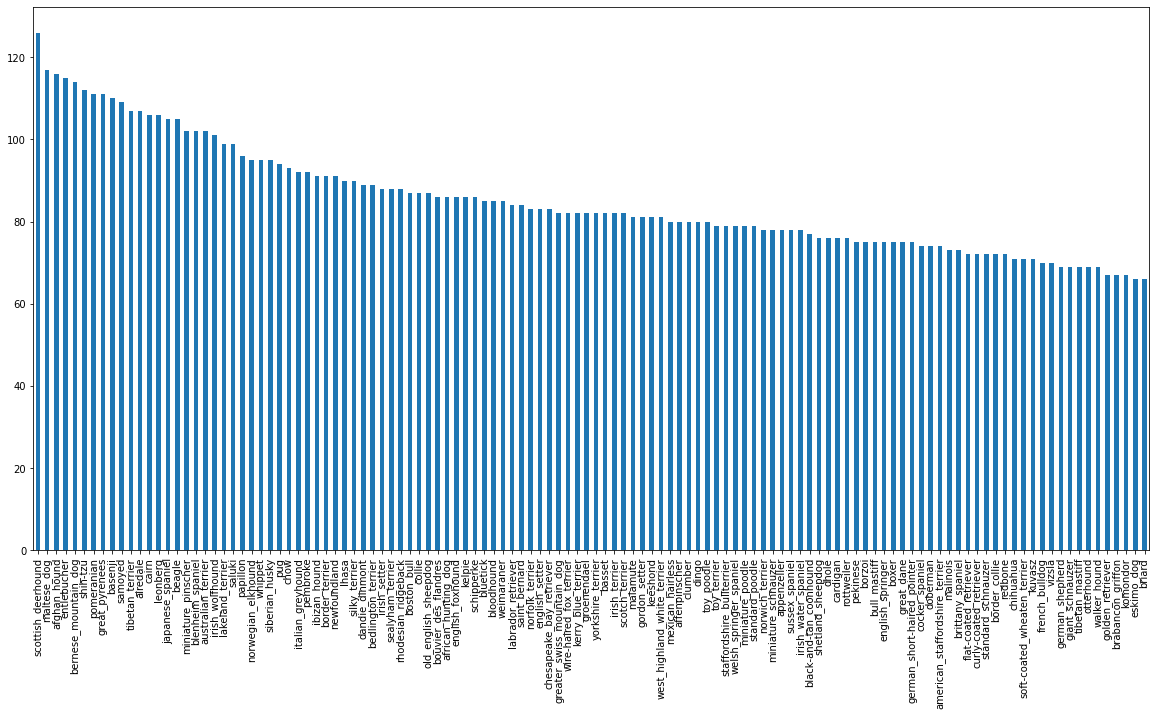

In [6]:
# Visualize no. of images per breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [7]:
# approximate no. of images per breed (per class)
labels_csv["breed"].value_counts().median()

82.0

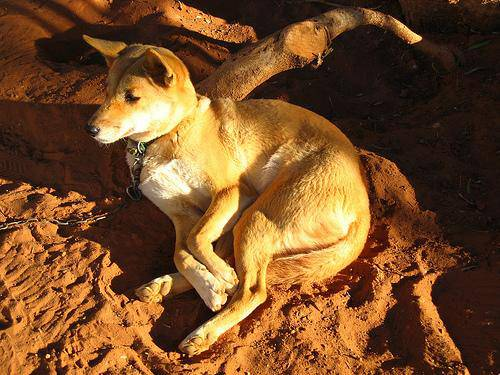

In [8]:
# let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames.

In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# create pathnames from image ID's
filenames = ["drive/MyDrive/Dog Vision/train/"+fname+ ".jpg" for fname in labels_csv["id"]]

# check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether no. of filenames matches actual number of image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train")) == len(filenames):
  print("Filenames match actual no. of image files.")
else:
  print("Filenames do not match actual no. of image files.")

Filenames match actual no. of image files.


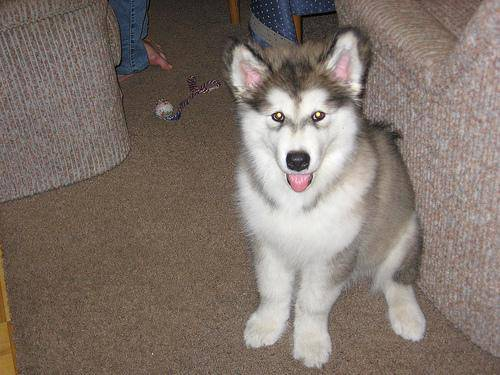

In [12]:
# checking some random image
Image(filenames[3000])

In [13]:
labels_csv["breed"][3000]

'malamute'

Since we've got our training image filenames in a list, let's prepare our labels.

In [14]:
# Preparing labels

import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# Check if number of labels matches with the no. of filenames (checking for missing data)
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match no. of filenames.")

Number of labels matches number of filenames


In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

### Turning Data labels into Numbers

In [18]:
# Turn a single label into a boolean array
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels), type(boolean_labels), np.array(boolean_labels).shape

(10222, list, (10222, 120))

In [21]:
labels[0]

'boston_bull'

In [22]:
labels_csv[:5]

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [23]:
# Example: turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0])) # index where label occurs in unique_breeeds
print(boolean_labels[0].argmax())  # index where label occurs in boolean array
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [24]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own Validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [25]:
# Setup x and y
x = filenames
y = boolean_labels

We're going to start off with experimenting ~1000 images and increase as needed.

In [26]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param{type:"slider", min:1000, max:10000, step:1000}

In [27]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# split them into training and validation sets of total size NUM_IMAGES
x_train, x_valid, y_train, y_valid = train_test_split(x[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)

len(x_train), len(y_train), len(x_valid), len(y_valid)

(800, 800, 200, 200)

In [28]:
# Let's have a look at the training data
x_train[:2], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

## Preprocessing Images (turning images into tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the image and save it to variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image` 

In [29]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [30]:
type(image)

numpy.ndarray

In [31]:
image.min(), image.max()

(0, 255)

In [32]:
# turning the image numpy array into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [33]:
type(tf.constant(image))

tensorflow.python.framework.ops.EagerTensor

Now we've seen what an image looks like as a tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the image and save it to variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image` 

In [34]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a tensor.
  """
  # Read in an image file 
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numerical tensor with 3 color channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values (normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning our data into batches

Why turn our data into **batches**?

If we try to process all 10,000+ images in one go, they all might not fit into memory.

So, that's why we do about 32 (batch size) images at a time (you can manually adjust the batch size if needed).

In order to use TensorFlow effectively, we need our data in the form of **Tensor tuples** which look like this:
`(image, label)`.

In [35]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  process the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)

  return image, label

In [36]:
get_image_label(x[26], tf.constant(y[26]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.25410587, 0.2894    , 0.2776353 ],
         [0.29784313, 0.33313724, 0.32137254],
         [0.29804096, 0.33333507, 0.32157037],
         ...,
         [0.41461015, 0.46559054, 0.38715917],
         [0.44833592, 0.4993163 , 0.42088494],
         [0.44921985, 0.5002003 , 0.42176887]],
 
        [[0.27608263, 0.31137675, 0.29961205],
         [0.30547515, 0.34076926, 0.32900456],
         [0.2880393 , 0.3233334 , 0.3115687 ],
         ...,
         [0.41783687, 0.46881726, 0.3903859 ],
         [0.46009547, 0.51107585, 0.4326445 ],
         [0.48616162, 0.537142  , 0.45871064]],
 
        [[0.29875293, 0.33404705, 0.3144392 ],
         [0.27189255, 0.30718666, 0.28757882],
         [0.28608775, 0.32138187, 0.30177402],
         ...,
         [0.47503573, 0.5260161 , 0.44758475],
         [0.49345425, 0.54443467, 0.46600327],
         [0.4703167 , 0.5212971 , 0.44286573]],
 
        ...,
 
        [[0.77551085, 0.7260472 

Now we've got a way to turn our data into tuple of Tensors in the form: `(image, label)`, let's make a function to turn all of our data ( `x` and `y`) into batches.

In [37]:
# Define the batch size (32 is a good start)
BATCH_SIZE = 32

# Create a fucntion to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # if the data is test dataset, it won't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))   # only filepaths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a validation dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),  #filepaths  # returns a dataset object
                                              tf.constant(y)))  #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)  # maps 'get_image_label' function across the elements of 'data' dataset and then creates batches.
    return data_batch

  else:
    print("Creating training data batches...")
    # turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    
    # shuffling filepaths and labels before mapping image preprocessor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))
    
    #Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    
    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    
    return data_batch

In [38]:
# Creating training and validation data batches
train_data = create_data_batches(x_train, y_train)
valid_data = create_data_batches(x_valid, y_valid, valid_data=True)

Creating training data batches...
Creating validation data batches..


In [39]:
# Check out different attributes of data batches
train_data.element_spec  # returns type specification of an element of this dataset.

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

In [40]:
valid_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand, let's visualize them.

In [41]:
import matplotlib.pyplot as plt

# Create a function for viewing images in data batches
def show_25_images(images, labels):
  """
  Displays a plot fo 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(15,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(images[i])
    # add image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    #turn the grid lines off
    plt.axis("off")

In [42]:
train_images, train_labels = next(train_data.as_numpy_iterator())   # as_numpy_iterator() - Returns an iterator which converts all elements of the dataset to numpy.
len(train_images), len(train_labels)

(32, 32)

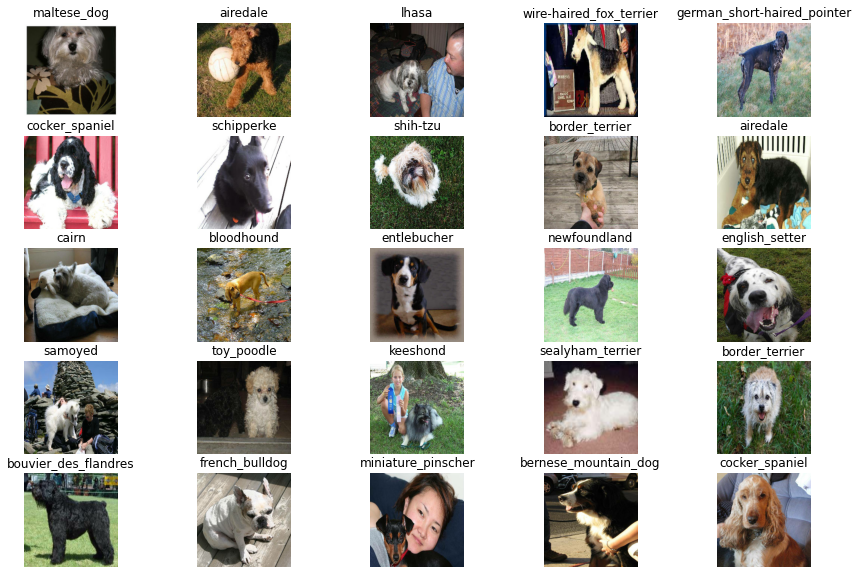

In [43]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

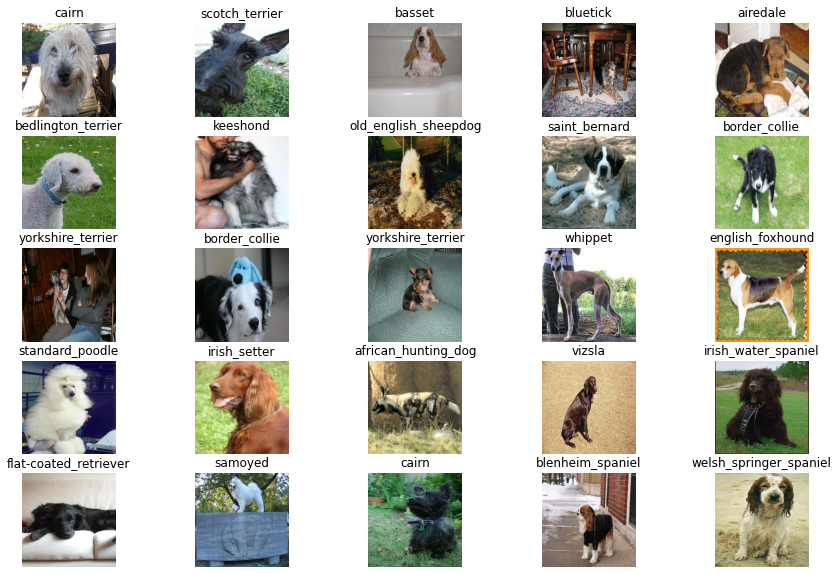

In [44]:
# Now let's visualize the data in a validation batch
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_25_images(valid_images, valid_labels)

## Building a model

Before we build a model, there a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from Tensorflow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [45]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model.

Helpful resource for Keras: https://www.tensorflow.org/guide/keras/sequential_model

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Build the model (tells the model the input shape it'll be getting).
* Returns the model. 

In [46]:
# Create a function which build Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # layer 2 (output layer)                           
  ])

  # compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics=["Accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [47]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to do things such as saving it's progress, check it's progress, or stop training early if a model stops improving.

We'll create two callbacks, one for **TensorBoard** which helps track our model's progress and another for **early stopping** which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it our model's `fit` function.
3. Visualize our model's training logs with `%tensorboard` magic function. 

In [48]:
# load TensorBoard notebook extension
# %load_ext tensorboard

In [49]:
import datetime

# create a function to build tensorboard callback
def create_tensorboard_callback():
   # Create a log directory for storing tensorboard logs
   logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                         # make it so the logs get tracked whenever we run an expirement
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
   return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping CallBack

Early stopping helps prevent **overfitting** by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

Helpful resource for understanding Early Stopping: https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

In [50]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_Accuracy', min_delta=0, patience=2, mode='max') # stops after 5 rounds of no improvements

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [51]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [52]:
NUM_EPOCHS

100

In [53]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


Let's create a function which trains a model.

* Create a model using `create_model()` 
* Setup a tensorboard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [54]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [55]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 105s 4s/step - loss: 4.4474 - Accuracy: 0.1075 - val_loss: 3.4174 - val_Accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 38s 2s/step - loss: 1.5634 - Accuracy: 0.7150 - val_loss: 2.1752 - val_Accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 39s 2s/step - loss: 0.5477 - Accuracy: 0.9388 - val_loss: 1.6798 - val_Accuracy: 0.6150
Epoch 4/100
25/25 [==============================] - 42s 2s/step - loss: 0.2419 - Accuracy: 0.9887 - val_loss: 1.5014 - val_Accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 39s 2s/step - loss: 0.1433 - Accuracy: 0.9950 - val_loss: 1.4297 - val_Accuracy: 0.6550
Epoch 6/100
25/25 [==============================] - 42s 2s/step - loss: 0.0979 - Accuracy: 1.0000 - val_loss: 1.3643 - val_Accuracy: 0.6700
Epoch 7/100
25/25 [==============================] - 42s 2s/

It looks like our model might be overfitting (getting far better results on the training set than the validation set), what are some ways to prevent model overfitting? Hint: this may involve searching something like "ways to prevent overfitting in a deep learning model?".

**Note**: Overfitting to begin with is a good thing. It means our model is learning something.

###Checking the TensorBoard logs

Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

Helpful resource: https://towardsdatascience.com/visualizing-your-model-using-tensorboard-796ebb73e98d

In [56]:
# %tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

## Making and evaluation predictions using a trained model

In [57]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [58]:
# make predictions on validation data (not used in training)
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 8s 1s/step


array([[2.52489070e-03, 2.72371894e-04, 1.18910836e-03, ...,
        3.82908300e-04, 8.54324462e-05, 1.48287695e-02],
       [2.52263807e-03, 5.30028774e-04, 1.93502381e-02, ...,
        9.85186081e-04, 2.06956193e-02, 2.18633038e-04],
       [1.24261041e-05, 1.36494171e-04, 3.92932208e-07, ...,
        2.56923449e-05, 3.70834641e-06, 1.25531398e-04],
       ...,
       [1.66860584e-04, 1.15304734e-04, 6.36294208e-05, ...,
        1.10928459e-05, 1.02950772e-03, 6.13497919e-04],
       [6.56251935e-03, 6.28778245e-04, 2.36880922e-04, ...,
        1.48765816e-04, 1.12139045e-04, 3.20348167e-03],
       [3.10974458e-04, 3.92452639e-05, 1.44177955e-03, ...,
        1.33587199e-03, 1.02805533e-03, 6.58899444e-05]], dtype=float32)

In [59]:
type(predictions), predictions.shape # 200 arrays each of 120 numbers

(numpy.ndarray, (200, 120))

In [60]:
len(x_valid), len(y_valid)

(200, 200)

In [61]:
predictions[0]  # returns probability value for each label

array([2.52489070e-03, 2.72371894e-04, 1.18910836e-03, 2.97587423e-04,
       3.45881330e-04, 5.26915101e-05, 5.09591140e-02, 6.00063941e-04,
       1.90138147e-04, 6.16221223e-04, 4.87961370e-04, 2.36889857e-04,
       2.37219356e-04, 1.65137244e-04, 1.23773108e-03, 6.80658035e-04,
       7.07787840e-05, 6.89066127e-02, 1.07307947e-04, 1.42360324e-04,
       1.65489607e-03, 1.60899232e-04, 6.64488380e-06, 2.68910779e-04,
       8.41799992e-05, 1.26894593e-04, 2.27618441e-01, 2.00363531e-04,
       2.02302195e-04, 1.76405185e-03, 4.15864459e-04, 5.65127586e-04,
       1.53507106e-04, 8.38411725e-05, 4.50118183e-04, 1.09667890e-02,
       4.52503227e-05, 1.36650982e-03, 1.17309406e-04, 3.65482410e-04,
       7.82189949e-04, 1.60783875e-05, 1.30217493e-04, 1.84229866e-04,
       5.22611226e-05, 6.90936868e-04, 5.24038114e-05, 2.71945057e-04,
       1.37458032e-03, 9.23672706e-05, 2.12648345e-04, 1.18061653e-04,
       1.00021868e-03, 1.12799811e-04, 1.84526958e-04, 6.76995493e-04,
      

In [62]:
np.sum(predictions[0])

1.0000002

In [63]:
# Max probability and it's index
predictions[0].max(), predictions[0].argmax()

(0.22761844, 26)

In [64]:
# Predicted label
unique_breeds[predictions[0].argmax()]

'cairn'

In [65]:
# True label
unique_breeds[y_valid[0].argmax()]

'cairn'

**Note**: Prediction probabilities are also known as confidence levels.

In [66]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [67]:
# Get a prediction label based on prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

Now since our validation data is still in a batch dataset, we'll have to unbatch it to make predictions on validation images and then compare those predictions to the validation labels (truth labels).

In [68]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [69]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) tensors and returns separate arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

In [70]:
# Unbatchify valdiation data
val_images, val_labels = unbatchify(valid_data)

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visual.

We'll create a function which:
* Takes an array of prediction probailities, an array of truth labels and an array of images and an integer.
* Convert the prediction probailities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [71]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth
  plt.title("{} {:.2f}% {}".format(pred_label,
                                   np.max(pred_prob)*100,
                                   true_label),
                                   color=color)

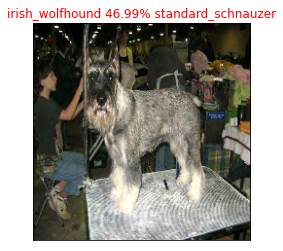

In [72]:
plot_pred(prediction_probabilities=predictions,
          labels = val_labels,
          images = val_images,
          n=150)

Now we've got one function to visualize our models top prediction, let's make another to view our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array, ground truth array and an integer.
* Find the predicted label using `get_pred_label()` 
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 probability values and labels, coloring the true label green.


In [73]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]
  
  # Setup plot
  top_plot  = plt.bar(np.arange(len(top_10_pred_labels)),
                      top_10_pred_values,
                      color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


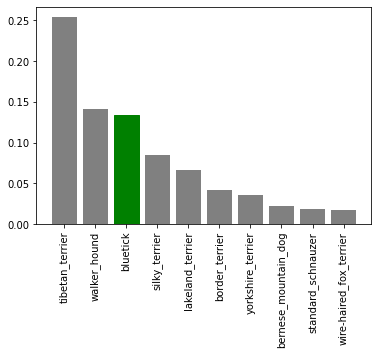

In [74]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=3)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

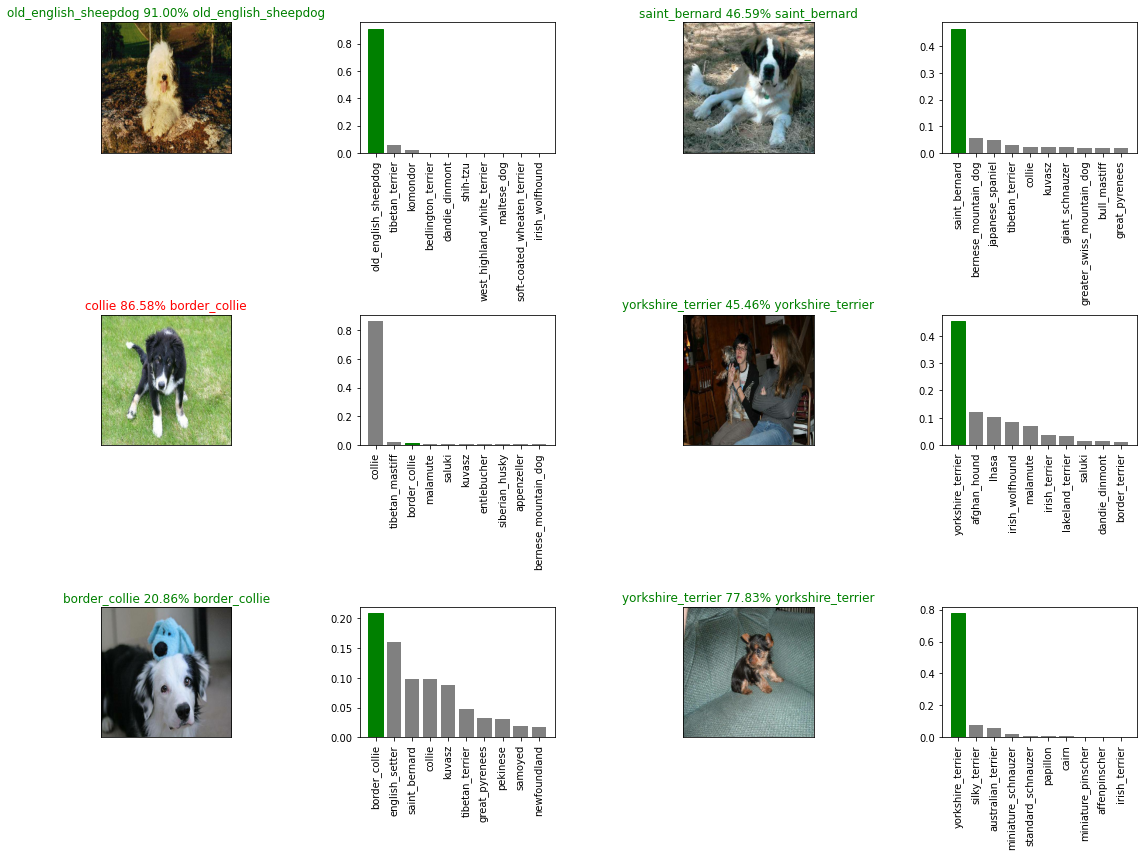

In [75]:
# Let's checkout a few predictions and their different values
i_multiplier = 7
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(8*num_cols, 4*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels = val_labels,
            images = val_images,
            n = i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels = val_labels,
                 n = i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [76]:
# create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a given model directory and appends a suffix (str).
  """
  # create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  
  model_path = modeldir + "-" + suffix + ".h5"  # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [77]:
# create a function to load a model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model 

Now we've got functions to save and load a trained model, let's make sure they work!

In [78]:
# save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20210908-08321631089957-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20210908-08321631089957-1000-images-mobilenetv2-Adam.h5'

In [79]:
# Load the trained model
loaded_1000_image_model = load_model("drive/MyDrive/Dog Vision/models/20210908-04161631074570-1000-images-mobilenetv2-Adam.h5")


Loading saved model from: drive/MyDrive/Dog Vision/models/20210908-04161631074570-1000-images-mobilenetv2-Adam.h5


In [80]:
# Evaluate the pre-saved model (before saving)
model.evaluate(valid_data)

7/7 [==============================] - 8s 1s/step - loss: 1.2858 - Accuracy: 0.6750


[1.2858389616012573, 0.675000011920929]

In [81]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 8s 1s/step - loss: 1.2351 - Accuracy: 0.6700


[1.2350902557373047, 0.6700000166893005]

## Training a big dog model (on full data!)

In [82]:
# Actual full training data
len(x), len(y)

(10222, 10222)

In [83]:
# Create a data batch with the full dataset
full_data = create_data_batches(x,y)

Creating training data batches...


In [84]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [85]:
# Create a model for full data
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [86]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="Accuracy",
                                                             patience=3,
                                                             mode="max")

In [87]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [89]:
# Fit the full model to full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 914s 3s/step - loss: 1.3399 - Accuracy: 0.6711
Epoch 2/100
320/320 [==============================] - 443s 1s/step - loss: 0.3968 - Accuracy: 0.8854
Epoch 3/100
320/320 [==============================] - 440s 1s/step - loss: 0.2366 - Accuracy: 0.9384
Epoch 4/100
320/320 [==============================] - 442s 1s/step - loss: 0.1535 - Accuracy: 0.9636
Epoch 5/100
320/320 [==============================] - 452s 1s/step - loss: 0.1076 - Accuracy: 0.9781
Epoch 6/100
320/320 [==============================] - 457s 1s/step - loss: 0.0782 - Accuracy: 0.9864
Epoch 7/100
320/320 [==============================] - 458s 1s/step - loss: 0.0588 - Accuracy: 0.9924
Epoch 8/100
320/320 [==============================] - 456s 1s/step - loss: 0.0476 - Accuracy: 0.9934
Epoch 9/100
320/320 [==============================] - 450s 1s/step - loss: 0.0381 - Accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 459s 1s/step - loss: 0.030

In [90]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20210908-11321631100726-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20210908-11321631100726-full-image-set-mobilenetv2-Adam.h5'

In [92]:
# Load in the full model
loaded_full_model = load_model("drive/MyDrive/Dog Vision/models/20210908-11321631100726-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/models/20210908-11321631100726-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

To make predictions on the test data we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data()` parameter to `True` (since the test data doesn't have labels.)
* Make a predictions array by passing the test batches to the `predict()` called on our model.

In [93]:
# Load test image filenames
test_path = "drive/MyDrive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

In [94]:
3 # create test data batches
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [95]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on pur full model and passing it the test data batch will take a long time to run (about ~1 hr).

In [97]:
# make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                                 verbose=1)

324/324 [==============================] - 1051s 3s/step


In [99]:
# Save predictions (numpy array) to a csv file
np.savetxt("drive/MyDrive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [100]:
# Load predictions (numpy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/Dog Vision/preds_array.csv", delimiter=",")

In [101]:
test_predictions.shape

(10357, 120)

# Preparing the test dataset predicitons

To get the data in this format, we'll:
* Create a pandas dataframe with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filpaths
* Add data (prediction probabilities) to rach of the dog breed columns.

In [102]:
# create a pandas dataframe with empty columns
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))

In [103]:
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [104]:
# Append test image ID's to predictiosn dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [107]:
# Add the prediction probailities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e66e1f3be08028cc17ea788657e014fa,1.31535e-05,7.89212e-10,4.90273e-10,2.32789e-09,2.09862e-07,2.10701e-09,1.06534e-05,1.92576e-09,4.85696e-09,6.8323e-10,2.21561e-12,7.83965e-07,1.83461e-07,2.14629e-11,7.199e-09,4.13408e-10,0.000272355,6.9474e-11,2.76129e-09,5.55059e-11,1.23385e-07,2.20711e-10,6.3072e-09,1.99967e-07,4.74961e-09,2.18887e-08,6.59712e-08,6.27212e-08,7.68544e-10,1.26452e-09,0.000823324,1.58025e-07,1.9394e-08,3.21301e-07,7.81835e-10,2.62658e-08,1.03502e-06,1.25867e-07,7.72383e-09,...,2.36986e-06,2.3326e-07,2.11316e-10,1.26461e-08,1.34722e-06,3.80051e-08,2.98245e-07,1.15968e-05,3.17464e-10,5.01077e-10,4.46912e-08,5.79374e-09,6.76349e-11,3.03189e-10,1.5485e-06,0.0105482,3.36694e-07,2.06165e-09,2.19009e-11,1.9541e-05,1.16882e-10,1.2915e-07,5.60241e-09,2.68647e-09,3.99145e-07,3.50924e-07,4.51662e-11,2.10354e-08,9.35466e-07,5.74519e-08,1.42518e-09,2.07757e-10,1.87546e-11,2.06652e-10,9.2561e-10,3.79079e-12,2.01679e-09,5.75001e-11,6.89032e-09,6.03035e-11
1,e1e79b3edfb3579e46ad914bf755dbbc,2.27342e-09,9.1788e-14,2.92713e-08,8.19682e-11,1.6195e-08,2.72237e-05,2.14486e-08,0.219727,1.06168e-11,5.90351e-06,7.43598e-09,8.36722e-12,2.77283e-08,1.56122e-09,4.99332e-11,5.14874e-08,7.57575e-08,2.92147e-10,2.92315e-11,0.000156854,5.95736e-14,4.63299e-10,2.60455e-09,3.56572e-11,2.50876e-07,5.13794e-14,1.42557e-08,0.00115477,1.56367e-11,0.42485,1.19737e-10,3.8938e-10,5.89609e-12,9.31554e-09,1.69066e-12,3.06426e-12,8.41569e-08,1.35558e-08,5.687e-06,...,7.79583e-09,4.06699e-08,3.96717e-13,3.51269e-13,0.00869876,2.94318e-11,2.98951e-06,1.3074e-09,3.47707e-10,4.75338e-08,2.3252e-13,3.73266e-12,2.29459e-10,3.00531e-11,2.96916e-09,1.22387e-06,4.6564e-09,1.16879e-12,1.2997e-10,1.6801e-10,3.98094e-08,1.4977e-08,1.43563e-05,1.68051e-09,3.19072e-08,2.6177e-10,8.42334e-09,2.0953e-11,1.33932e-12,4.73023e-11,1.85564e-07,0.318713,1.59744e-09,2.06384e-10,2.777e-08,1.76121e-08,7.83152e-07,1.01767e-09,4.49249e-08,3.41962e-06
2,e4b76574d24800b91bdcfc886fb74f23,6.77119e-05,1.48452e-06,1.11794e-12,1.51045e-10,8.87684e-12,1.25457e-07,5.79439e-11,2.03302e-10,4.7554e-10,3.66293e-16,2.92537e-12,2.62414e-07,1.38307e-14,6.37511e-11,1.95207e-09,1.00342e-12,2.30283e-10,9.36125e-13,1.93605e-12,3.53804e-12,3.0699e-09,2.45127e-13,7.8347e-11,1.17519e-08,1.49458e-13,4.3654e-10,4.84451e-10,1.26956e-10,7.24246e-14,2.49097e-11,1.57277e-07,3.20598e-11,1.24701e-08,8.81241e-13,5.89143e-12,8.73924e-12,3.21557e-14,1.63272e-13,6.35654e-12,...,1.86486e-10,1.00607e-11,9.22146e-12,1.48383e-09,5.58166e-11,2.29632e-06,1.14908e-14,6.97961e-11,1.29041e-09,6.89408e-13,1.15078e-11,6.42778e-13,2.56003e-10,3.78355e-08,4.83906e-10,1.02455e-13,5.31653e-09,6.50438e-12,4.87426e-13,6.24335e-09,4.92119e-10,8.49233e-14,2.94202e-11,2.67788e-12,4.6919e-12,2.33744e-08,2.41002e-10,9.81205e-11,0.999895,7.60698e-07,4.97903e-06,1.25557e-10,3.65354e-13,9.92986e-13,8.99487e-12,7.2717e-14,1.63797e-12,1.72139e-15,7.7

In [108]:
# Save our predictions dataframe to csv
preds_df.to_csv("drive/MyDrive/Dog Vision/full_model_predictions_submission_1_mobilenetv2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()`  and since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted label to custom images.

In [132]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Dog Vision/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [133]:
custom_image_paths

['drive/MyDrive/Dog Vision/dogs/dog-photo-2.jpg',
 'drive/MyDrive/Dog Vision/dogs/dog-photo-1.jpg',
 'drive/MyDrive/Dog Vision/dogs/dog-photo-3.jpg']

In [134]:
# Turn custom images into batch dataset
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [135]:
custom_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [136]:
# Make predictions on test data
custom_preds = loaded_full_model.predict(custom_data)

In [137]:
custom_preds.shape

(3, 120)

In [138]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['tibetan_mastiff', 'malinois', 'afghan_hound']

In [139]:
custom_images = []
# Loop through unbatched data
for image in  custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

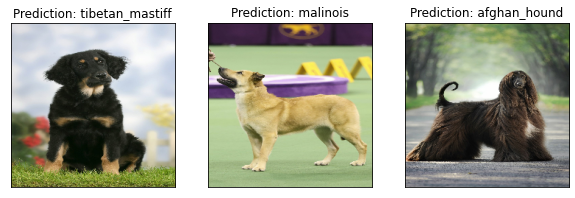

In [140]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title("Prediction: {}".format(custom_pred_labels[i]))
  plt.imshow(image)